In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score
)
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from imblearn.over_sampling import SMOTE
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# Heart Disease Prediction Analysis

This notebook analyzes heart disease data and builds a prediction model following these steps:

1. Data Loading and Initial Analysis
2. Missing Values Treatment
3. Exploratory Data Analysis (EDA)
4. Feature Engineering and Preprocessing
5. Model Building and Evaluation

In [2]:
# Step 1: Load and examine the data
# Load the dataset
df = pd.read_csv('heart_disease_uci.csv')
df_model = df.copy()

# Display basic information about the dataset
print("Dataset Shape:", df_model.shape)
print("\nBasic Information about the dataset:")
df_model.info()

# Display the first few rows
print("\nFirst few rows of the dataset:")
display(df_model.head())

# Check for missing values
print("\nMissing values in each column:")
missing_values = df_model.isnull().sum()
missing_percentages = (missing_values / len(df_model)) * 100
missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentages
})
print(missing_info[missing_info['Missing Values'] > 0])

Dataset Shape: (920, 16)

Basic Information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB

First few rows of the dataset:


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0



Missing values in each column:
          Missing Values  Percentage
trestbps              59    6.413043
chol                  30    3.260870
fbs                   90    9.782609
restecg                2    0.217391
thalch                55    5.978261
exang                 55    5.978261
oldpeak               62    6.739130
slope                309   33.586957
ca                   611   66.413043
thal                 486   52.826087


In [3]:
#drop dataset id column
df_model.drop(columns=['id','dataset'], inplace=True)

In [4]:

# Identify columns
categorical_cols = df_model.select_dtypes(include=['object']).columns
numerical_cols = df_model.select_dtypes(include=['int64', 'float64']).columns


In [5]:
# ---------------------------
# 2. Feature Engineering
# ---------------------------
df_model['chol_per_age'] = df_model['chol'] / (df_model['age'] + 1e-5)
df_model['heart_rate_reserve'] = df_model['thalch'] - df_model['trestbps']
df_model['risk_score'] = (
    (df_model['age'] > 50).astype(int) +
    (df_model['chol'] > 240).astype(int) +
    (df_model['fbs'] == 1).astype(int)
)

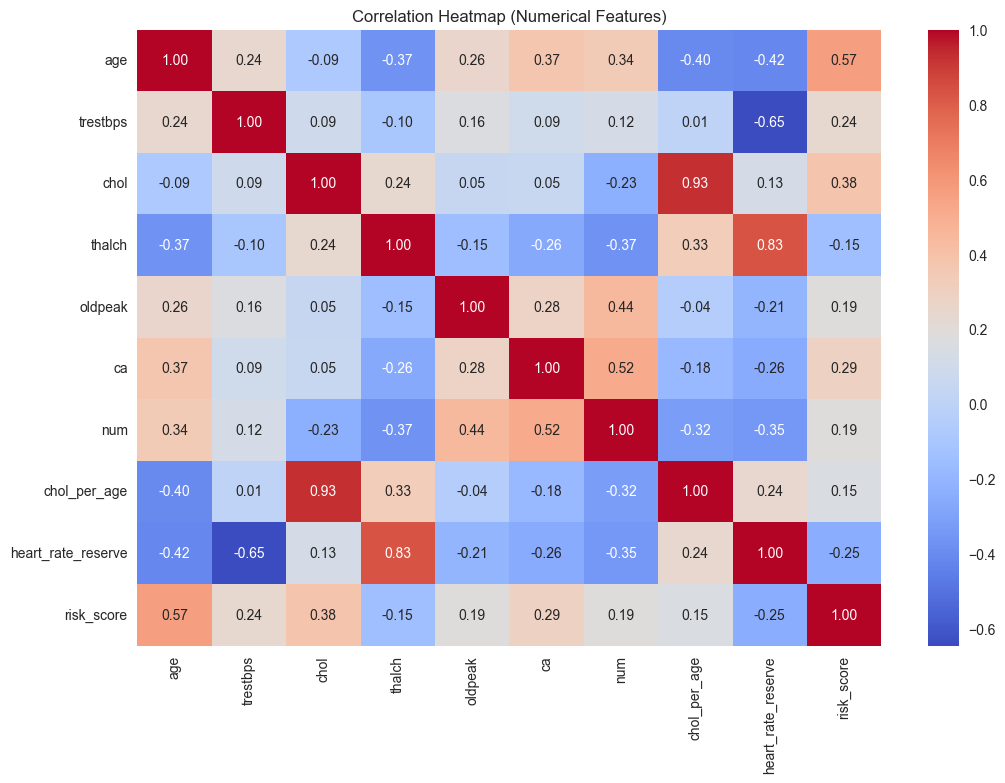


Correlation Ratio for Categorical Features:
   Feature  Correlation_Ratio
1       cp           0.447646
4    exang           0.372757
6     thal           0.329838
5    slope           0.286781
0      sex           0.259342
3  restecg           0.172629
2      fbs           0.153581


In [6]:
# 3.2 Correlation Analysis
# ---------------------------

# Numerical correlations (Pearson)
numerical_cols = df_model.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()

# Categorical correlations using Correlation Ratio (Eta)

eta_results = {}

for col in categorical_cols:
    fcat, _ = pd.factorize(df_model[col])
    cat_num = np.max(fcat) + 1
    values = df_model['num'].values
    y_avg = np.mean(values)
    
    numerator = 0
    denominator = np.sum((values - y_avg) ** 2)
    
    for i in range(cat_num):
        yi = values[np.argwhere(fcat == i).flatten()]
        ni = len(yi)
        numerator += ni * (np.mean(yi) - y_avg) ** 2
    
    eta = np.sqrt(numerator / denominator)
    eta_results[col] = eta

eta_df = pd.DataFrame(list(eta_results.items()), columns=['Feature', 'Correlation_Ratio'])
print("\nCorrelation Ratio for Categorical Features:")
print(eta_df.sort_values(by='Correlation_Ratio', ascending=False))



In [7]:

df_temp = df_model.copy()

# ---------------------------
# 1. Handle numerical columns with median
numerical_columns = [ 'chol_per_age','heart_rate_reserve' ,'trestbps' ,'chol', 'thalch', 'oldpeak']
for col in numerical_columns:
    df_temp[col].fillna(df_temp[col].median(), inplace=True)

# 2. Handle categorical columns with mode
categorical_columns = ['restecg', 'fbs', 'exang']
for col in categorical_columns:
    df_temp[col].fillna(df_temp[col].mode()[0], inplace=True)

# ---------------------------
# 3. Handle 'ca' column with KNN
imputer = KNNImputer(n_neighbors=5)
df_temp[['ca']] = imputer.fit_transform(df_temp[['ca']])

# ---------------------------
# 4. Encode all categorical columns to numeric before RandomForest
le_dict = {}
for col in df_temp.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df_temp[col] = le.fit_transform(df_temp[col].astype(str))
    le_dict[col] = le

# ---------------------------
# 5. RandomForest imputation for 'slope' and 'thal'
label_cols = ['slope', 'thal']

for target_col in label_cols:
    missing_idx = df_temp[target_col].isna()
    n_missing = missing_idx.sum()
    print(f"Missing values in {target_col}: {n_missing}")
    
    if n_missing == 0:
        continue
    
    features = df_temp.drop(columns=['num'] + label_cols)
    target = df_temp[target_col]
    
    X_train = features[~missing_idx]
    y_train = target[~missing_idx]
    X_missing = features[missing_idx]
    
    # Detect type: classification or regression
    if y_train.dtype == 'object' or y_train.nunique() < 20:
        model = RandomForestClassifier(random_state=42)
    else:
        model = RandomForestRegressor(random_state=42)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_missing)
    
    # Fill missing values
    df_temp.loc[missing_idx, target_col] = y_pred
    print(f"Filled {n_missing} missing values in {target_col}")

# ---------------------------
# 6. Update original DataFrame
df_model = df_temp.copy()

print("\nMissing values after imputation:")
print(df_model.isnull().sum())


Missing values in slope: 0
Missing values in thal: 0

Missing values after imputation:
age                   0
sex                   0
cp                    0
trestbps              0
chol                  0
fbs                   0
restecg               0
thalch                0
exang                 0
oldpeak               0
slope                 0
ca                    0
thal                  0
num                   0
chol_per_age          0
heart_rate_reserve    0
risk_score            0
dtype: int64


In [8]:
#
df_model['num'] = df_model['num'].apply(lambda x: 1 if x > 0 else 0)

In [9]:

# 3. One-hot encoding for categorical variables
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)


In [10]:
X = df_model.drop('num', axis=1)
y = df_model['num']
# ---------------------------
# 3️⃣ Standard Scaling
# ---------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_clean = pd.DataFrame(X_scaled, columns=X.columns)

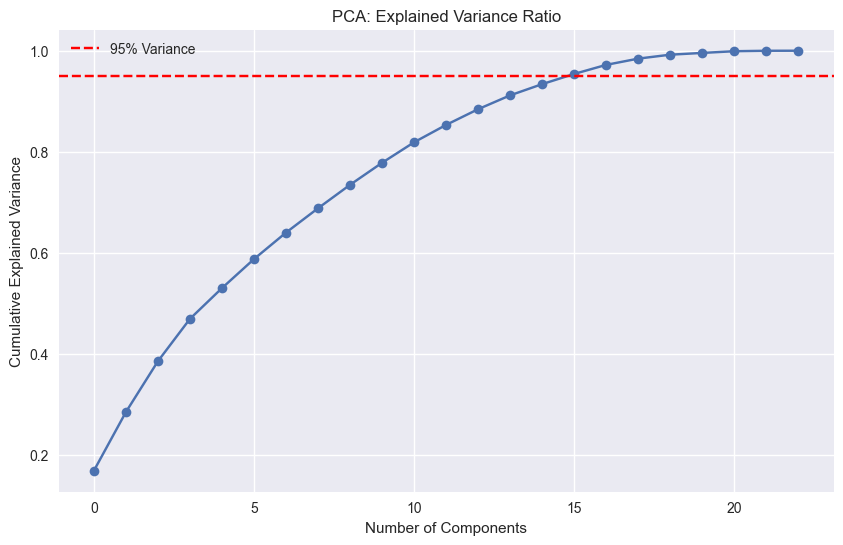

Optimal number of PCA components: 16


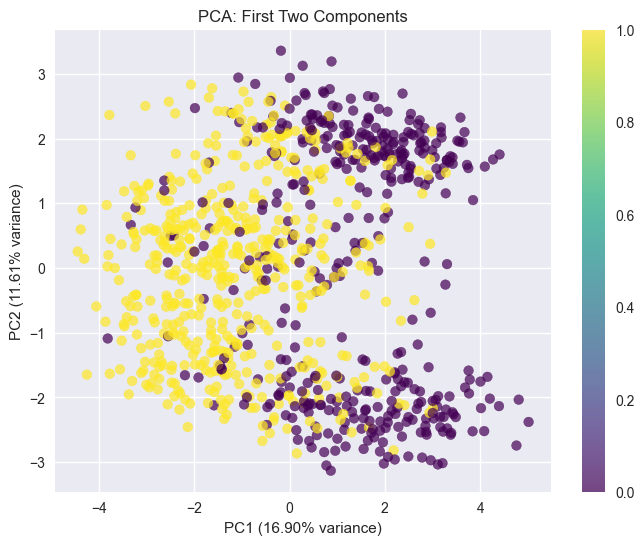

In [11]:
# PCA - Dimensionality Reduction
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance Ratio')
plt.legend()
plt.grid(True)
plt.show()

# Determine optimal number of components
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Optimal number of PCA components: {n_components}")

# Apply PCA
pca_final = PCA(n_components=n_components)
X_pca_reduced = pca_final.fit_transform(X_scaled)

# Scatter plot of first two principal components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca_reduced[:, 0], X_pca_reduced[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]:.2%} variance)')
plt.title('PCA: First Two Components')
plt.show()


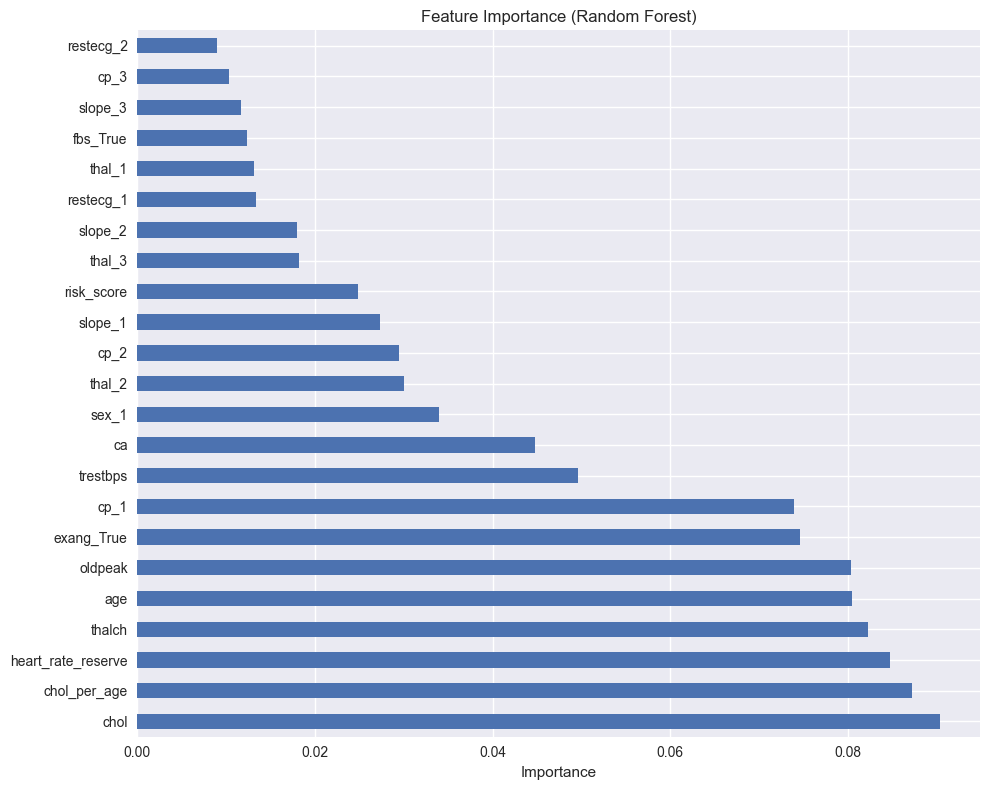

Reduced dataset with 17 key features:
['thal_2', 'age', 'ca', 'sex_1', 'chol', 'slope_3', 'exang_True', 'heart_rate_reserve', 'cp_1', 'slope_1', 'slope_2', 'thalch', 'cp_2', 'trestbps', 'chol_per_age', 'thal_3', 'oldpeak']


In [12]:
# 1. Feature Importance using Random Forest
rf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_temp.fit(X_scaled, y)

feature_importance = pd.Series(rf_temp.feature_importances_, index=X.columns)
feature_importance.sort_values(ascending=False).plot(kind='barh', figsize=(10, 8))
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# 2. Recursive Feature Elimination (RFE)
rfe = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=10)
X_rfe = rfe.fit_transform(X_scaled, y)
selected_rfe = X.columns[rfe.support_]

# 3. Chi-Square Test
X_positive = MinMaxScaler().fit_transform(X_scaled)
chi2_selector = SelectKBest(chi2, k=10)
X_chi2 = chi2_selector.fit_transform(X_positive, y)
selected_chi2 = X.columns[chi2_selector.get_support()]

# 4. Final selected features
final_features = list(set(selected_rfe) | set(selected_chi2))
X_selected = X[final_features]
X_selected_scaled = StandardScaler().fit_transform(X_selected)

print(f"Reduced dataset with {len(final_features)} key features:")
print(final_features)

In [13]:
# Polynomial Features for Logistic Regression (degree=2)
print("Creating Polynomial Features (degree=2) for Logistic Regression...")
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_selected_scaled)

# Scale polynomial features
poly_scaler = StandardScaler()
X_poly_scaled = poly_scaler.fit_transform(X_poly)

# Train-test split for polynomial data
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(
    X_poly_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to balance classes
smote_poly = SMOTE(random_state=42)
X_train_poly_bal, y_train_poly_bal = smote_poly.fit_resample(X_train_poly, y_train_poly)

# Train Logistic Regression on Polynomial Features
log_reg_poly = LogisticRegression(
    max_iter=2000,
    C=1.0,
    penalty='l2',
    solver='liblinear',
    random_state=42
)
log_reg_poly.fit(X_train_poly_bal, y_train_poly_bal)
y_pred_poly = log_reg_poly.predict(X_test_poly)
y_pred_proba_poly = log_reg_poly.predict_proba(X_test_poly)[:, 1]

# Initialize results dictionary
results = {}
results["Logistic Regression (Poly d=2)"] = {
    'Accuracy': accuracy_score(y_test_poly, y_pred_poly),
    'Precision': precision_score(y_test_poly, y_pred_poly),
    'Recall': recall_score(y_test_poly, y_pred_poly),
    'F1': f1_score(y_test_poly, y_pred_poly),
    'AUC': roc_auc_score(y_test_poly, y_pred_proba_poly)
}

# Baseline Training on Original Features
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_selected_scaled, y, test_size=0.2, random_state=42, stratify=y
)

smote_orig = SMOTE(random_state=42)
X_train_orig_bal, y_train_orig_bal = smote_orig.fit_resample(X_train_orig, y_train_orig)

baseline_models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

model_data = {
    "Decision Tree": (X_train_orig_bal, X_test_orig),
    "Random Forest": (X_train_orig_bal, X_test_orig),
    "SVM": (X_train_orig_bal, X_test_orig),
    "XGBoost": (X_train_orig_bal, X_test_orig)
}

baseline_results = {}
for name, model in baseline_models.items():
    X_train_data, X_test_data = model_data[name]
    model.fit(X_train_data, y_train_orig_bal)
    y_pred = model.predict(X_test_data)
    y_proba = model.predict_proba(X_test_data)[:, 1]
    baseline_results[name] = {
        'Accuracy': accuracy_score(y_test_orig, y_pred),
        'F1': f1_score(y_test_orig, y_pred),
        'AUC': roc_auc_score(y_test_orig, y_proba)
    }

# Combine all baseline results
all_baseline = {**results, **baseline_results}
baseline_df = pd.DataFrame(all_baseline).T.round(4)
print("\nBaseline Model Performance (Before Tuning):")
print(baseline_df)


Creating Polynomial Features (degree=2) for Logistic Regression...

Baseline Model Performance (Before Tuning):
                                Accuracy  Precision  Recall      F1     AUC
Logistic Regression (Poly d=2)    0.8098     0.8131  0.8529  0.8325  0.8739
Decision Tree                     0.7609        NaN     NaN  0.7822  0.7592
Random Forest                     0.8478        NaN     NaN  0.8627  0.8903
SVM                               0.8424        NaN     NaN  0.8612  0.9097
XGBoost                           0.8261        NaN     NaN  0.8447  0.8746


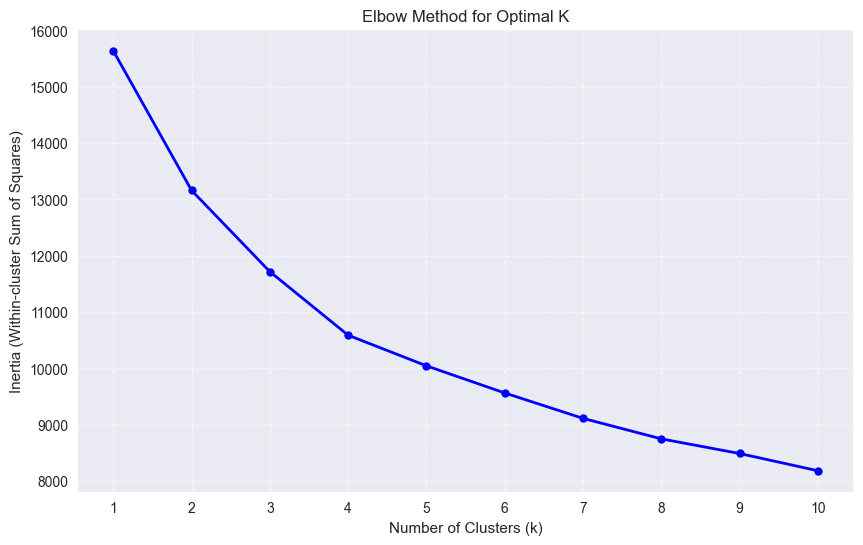

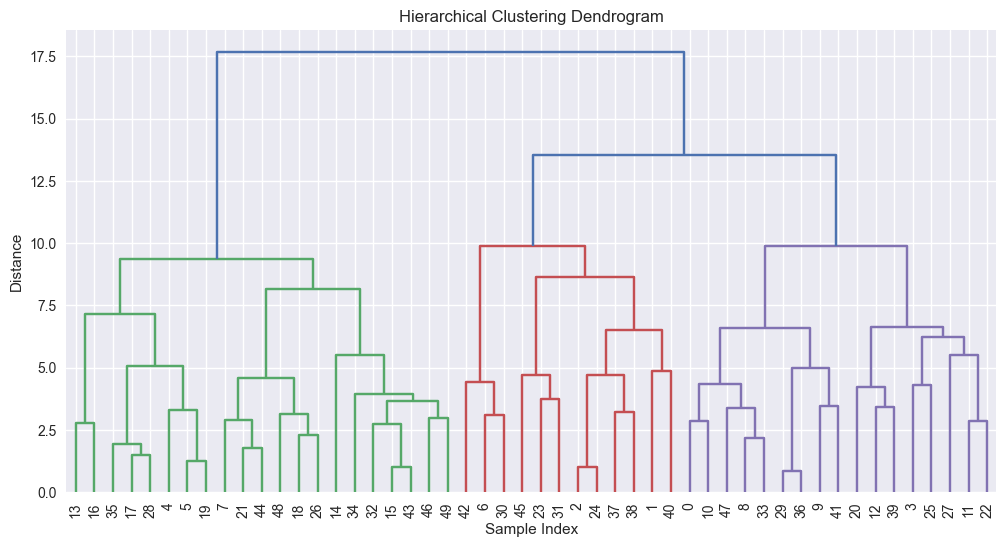

K-Means Clusters vs Actual Disease Labels:
True_Label    0    1
Cluster             
0           343  134
1            68  375
Cluster 0: 477 patients, 134 have heart disease (28.1%)
Cluster 1: 443 patients, 375 have heart disease (84.7%)


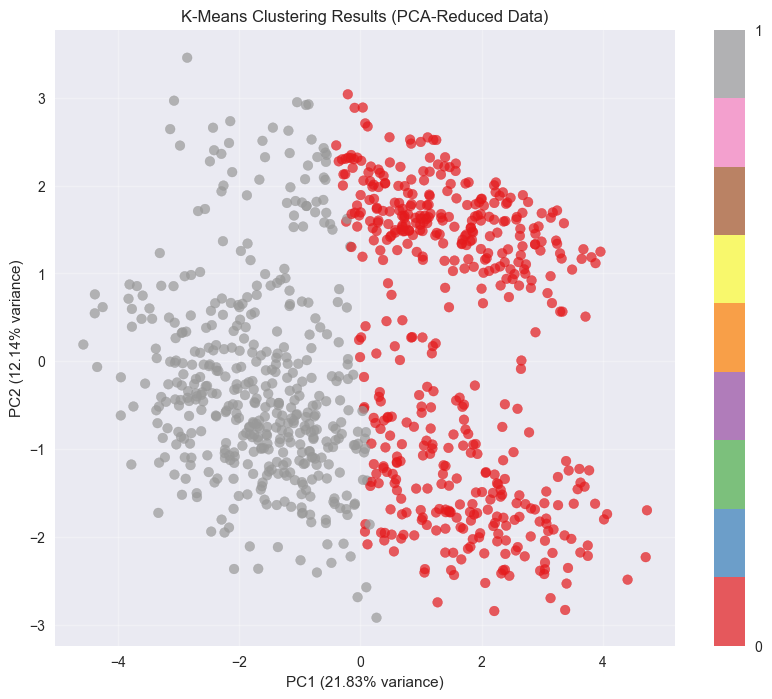

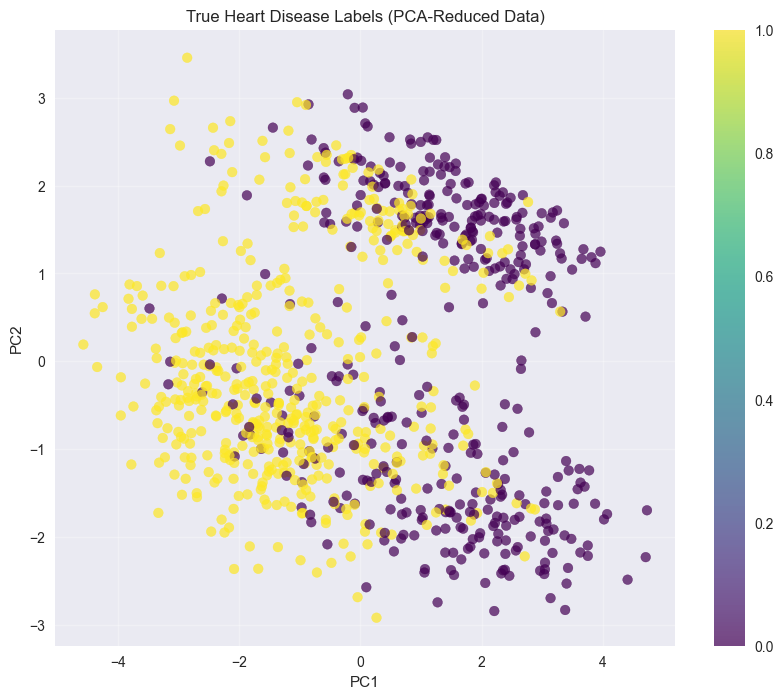


Clustering Evaluation:
Adjusted Rand Index: 0.3138
Silhouette Score: 0.1553


In [14]:
# Unsupervised Learning - Clustering
X_cluster = X_selected_scaled
y_true = y

# K-Means Clustering with Elbow Method
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_cluster)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=6)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(k_range)
plt.show()

# Apply K-Means with k=2
kmeans_final = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_cluster)

# Hierarchical Clustering Dendrogram (on sample)
sample_size = 50
X_sample = X_cluster[:sample_size]
linked = linkage(X_sample, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linked, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

# Compare clusters with true labels
comparison_df = pd.DataFrame({'True_Label': y_true, 'Cluster': cluster_labels})
contingency_table = pd.crosstab(comparison_df['Cluster'], comparison_df['True_Label'])
print("K-Means Clusters vs Actual Disease Labels:")
print(contingency_table)

for cluster in contingency_table.index:
    total = contingency_table.loc[cluster].sum()
    diseased = contingency_table.loc[cluster, 1] if 1 in contingency_table.columns else 0
    percent = (diseased / total) * 100 if total > 0 else 0
    print(f"Cluster {cluster}: {total} patients, {diseased} have heart disease ({percent:.1f}%)")

# Visualize clustering using PCA
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_cluster)

plt.figure(figsize=(10, 8))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=cluster_labels, cmap='Set1', alpha=0.7)
plt.colorbar(ticks=[0, 1])
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} variance)')
plt.title('K-Means Clustering Results (PCA-Reduced Data)')
plt.grid(True, alpha=0.3)
plt.show()

# True labels for comparison
plt.figure(figsize=(10, 8))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_true, cmap='viridis', alpha=0.7)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('True Heart Disease Labels (PCA-Reduced Data)')
plt.grid(True, alpha=0.3)
plt.show()

# Clustering Evaluation
from sklearn.metrics import adjusted_rand_score, silhouette_score
ari = adjusted_rand_score(y_true, cluster_labels)
silhouette = silhouette_score(X_cluster, cluster_labels)
print(f"\nClustering Evaluation:")
print(f"Adjusted Rand Index: {ari:.4f}")
print(f"Silhouette Score: {silhouette:.4f}")

In [ ]:
# Hyperparameter Tuning
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grids = {
    "Logistic Regression (Poly d=2)": {
        'model': LogisticRegression(max_iter=2000, random_state=42),
        'random': {'C': [0.01, 0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear']},
        'grid': {'C': [0.1, 1, 10], 'penalty': ['l2'], 'solver': ['liblinear']}
    },
    "Decision Tree": {
        'model': DecisionTreeClassifier(random_state=42),
        'random': {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        },
        'grid': {
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'criterion': ['gini', 'entropy']
        }
    },
    "Random Forest": {
        'model': RandomForestClassifier(random_state=42),
        'random': {
            'n_estimators': [100, 150, 200, 300],
            'max_depth': [5, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        },
        'grid': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    "SVM": {
        'model': SVC(probability=True, random_state=42),
        'random': {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'kernel': ['rbf', 'linear']
        },
        'grid': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto', 0.01, 0.1],
            'kernel': ['rbf', 'linear']
        }
    },
    "XGBoost": {
        'model': XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            tree_method='hist'  
        ),
        'random': {
            'n_estimators': [100, 200, 300],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        },
        'grid': {
            'n_estimators': [100, 200],
            'max_depth': [6, 10],
            'learning_rate': [0.05, 0.1],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    }
}

# Store best models
best_models_random = {}
best_models_grid = {}

print("\nStarting Hyperparameter Tuning (Random + Grid Search)...\n")

for name in param_grids:
    print(f"Tuning: {name}")
    model = param_grids[name]['model']
    random_params = param_grids[name]['random']
    grid_params = param_grids[name]['grid']
    
    # Select training data
    X_train_data = X_train_poly_bal if "Poly" in name else X_train_orig_bal
    
    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        model, random_params, n_iter=10, cv=cv, scoring='f1',
        n_jobs=-1, random_state=42, error_score=0  
    )
    random_search.fit(X_train_data, y_train_orig_bal)
    best_models_random[name] = random_search.best_estimator_
    print(f"  RandomizedSearchCV Best Params: {random_search.best_params_}")
    
    # GridSearchCV
    grid_search = GridSearchCV(
        model, grid_params, cv=cv, scoring='f1',
        n_jobs=-1, error_score=0  # 
    )
    grid_search.fit(X_train_data, y_train_orig_bal)
    best_models_grid[name] = grid_search.best_estimator_
    print(f"  GridSearchCV Best Params: {grid_search.best_params_}\n")

# Evaluate models
def evaluate_models(model_dict, X_test_orig, X_test_poly, y_test):
    results = {}
    for name, model in model_dict.items():
        X_test_data = X_test_poly if "Poly" in name else X_test_orig
        y_pred = model.predict(X_test_data)
        y_proba = model.predict_proba(X_test_data)[:, 1]
        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'AUC': roc_auc_score(y_test, y_proba)
        }
    return pd.DataFrame(results).T.round(4)

results_random = evaluate_models(best_models_random, X_test_orig, X_test_poly, y_test_orig)
results_grid = evaluate_models(best_models_grid, X_test_orig, X_test_poly, y_test_orig)

print("Final Results - RandomizedSearchCV:")
print(results_random)
print("\nFinal Results - GridSearchCV:")
print(results_grid)

# Comparison
comparison = pd.concat([results_random['F1'], results_grid['F1']], axis=1)
comparison.columns = ['RandomizedSearchCV', 'GridSearchCV']
comparison['Improvement'] = comparison['GridSearchCV'] - comparison['RandomizedSearchCV']
print("\nComparison of F1 Scores:")
print(comparison.round(4))

# Best model
best_f1 = comparison['GridSearchCV'].max()
best_model_name = comparison['GridSearchCV'].idxmax()
print(f"\nBest Model: '{best_model_name}' with F1 = {best_f1:.4f}")


Starting Hyperparameter Tuning (Random + Grid Search)...

Tuning: Logistic Regression (Poly d=2)
  RandomizedSearchCV Best Params: {'solver': 'liblinear', 'penalty': 'l2', 'C': 0.01}
  GridSearchCV Best Params: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

Tuning: Decision Tree
  RandomizedSearchCV Best Params: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 7, 'criterion': 'entropy'}
  GridSearchCV Best Params: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}

Tuning: Random Forest
  RandomizedSearchCV Best Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 15, 'bootstrap': False}
  GridSearchCV Best Params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Tuning: SVM
  RandomizedSearchCV Best Params: {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}
  GridSearchCV Best Params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

Tuning: XGBoost
  RandomizedSearchCV Best